In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the input data
# data for 2022
train_Ground_truth_2022 = '/data/MLCAS2024/EvalAI/data/train/2022/DataPublication_final/GroundTruth/HYBRID_HIPS_V3.5_ALLPLOTS.csv'
train_Data_aquisition_time_2022 = '/data/MLCAS2024/EvalAI/data/train/2022/DataPublication_final/GroundTruth/DateofCollection.xlsx'
train_Satellite_2022 = '/data/MLCAS2024/EvalAI/data/train/2022/DataPublication_final/Satellite'

# data for 2023
train_Ground_truth_2023 = '/data/MLCAS2024/EvalAI/data/train/2023/DataPublication_final/GroundTruth/train_HIPS_HYBRIDS_2023_V2.3.csv'
train_Data_aquisition_time_2023 = '/data/MLCAS2024/EvalAI/data/train/2023/DataPublication_final/GroundTruth/DateofCollection.xlsx'
train_Satellite_2023 = '/data/MLCAS2024/EvalAI/data/train/2023/DataPublication_final/Satellite'

# validation data
val_Ground_truth = '/data/MLCAS2024/EvalAI/data/validation/2023/GroundTruth/val_HIPS_HYBRIDS_2023_V2.3.csv'
val_Data_aquisition_time = '/data/MLCAS2024/EvalAI/data/validation/DateofCollection.xlsx'
val_Satellite = '/data/MLCAS2024/EvalAI/data/validation/2023/Satellite'

# test data
test_Ground_truth = '/data/MLCAS2024/EvalAI/data/test/Test/GroundTruth/test_HIPS_HYBRIDS_2023_V2.3.csv'
test_Data_aquisition_time = '/data/MLCAS2024/EvalAI/data/validation/DateofCollection.xlsx'
test_Satellite = '/data/MLCAS2024/EvalAI/data/test/Test/Satellite'

# out csv file path and name

fn_out_final_validation = './validation_result_forsubmission.csv'
fn_out_final_test =  './test_result_forsubmission.csv'

In [ ]:
# read csv and xlsx files
train_Ground_truth_2022 = pd.read_csv (train_Ground_truth_2022)
train_Ground_truth_2023 = pd.read_csv (train_Ground_truth_2023)
val_Ground_truth = pd.read_csv(val_Ground_truth)
test_Ground_truth = pd.read_csv(test_Ground_truth)

train_Data_aquisition_time_2022 = pd.read_excel(train_Data_aquisition_time_2022)
train_Data_aquisition_time_2023 = pd.read_excel (train_Data_aquisition_time_2023)
val_Data_aquisition_time = pd.read_excel(val_Data_aquisition_time)
test_Data_aquisition_time = pd.read_excel (test_Data_aquisition_time)

In [ ]:
# extract features and yield 2022
train_GrT_2022 = train_Ground_truth_2022.loc[~train_Ground_truth_2022['yieldPerAcre'].isnull(), :]
train_GrT_2023 = train_Ground_truth_2023.loc[~train_Ground_truth_2023['yieldPerAcre'].isnull(), :]

print(f"Dimensions of Ground_truth_2022: {train_GrT_2022.shape}")
print(f"Dimensions of Ground_truth_2023: {train_GrT_2023.shape}")

Dimensions of Ground_truth_2022: (2131, 18)
Dimensions of Ground_truth_2023: (643, 17)


In [ ]:
import os

def find_satellite_imagery_paths(dataframe, data_acquisition_time, satellite_directory):
    # List to store the results
    results = []

    # Extract the specified columns
    columns_to_extract = [
    'location', 'irrigationProvided', 'poundsOfNitrogenPerAcre', 'experiment',
    'plotLength', 'block', 'row', 'range', 'genotype', 'plantingDate', 'yieldPerAcre'
    ]

    extracted_columns_df = dataframe[columns_to_extract]

    # Get unique combinations of location, experiment, range, and row
    unique_combinations = extracted_columns_df[['location', 'experiment', 'range', 'row']].drop_duplicates()

    # Traverse each unique combination
    for _, unique_row in unique_combinations.iterrows():
        location = unique_row['location']
        experiment = unique_row['experiment']
        range_val = unique_row['range']
        row_val = unique_row['row']

        # Initialize a dictionary to store the data for this plot
        plot_data = unique_row.to_dict()

        # Traverse the time point directories under the location
        # for timepoint_dir in os.listdir(os.path.join(satellite_directory, location)):
        for timepoint_dir in ['TP1', 'TP2', 'TP3', 'TP4', 'TP5', 'TP6' ]:
            plot_data[f'img_path_{timepoint_dir}'] = float('nan')
            plot_data[f'gap_days_{timepoint_dir}'] = float('nan')

        for timepoint_dir in ['TP1', 'TP2', 'TP3', 'TP4', 'TP5', 'TP6' ]:
            timepoint_path = os.path.join(satellite_directory, location, timepoint_dir)

            if not os.path.isdir(timepoint_path):
                print('this does not exit', timepoint_path)
                continue

            # Construct the expected file name
            expected_file_name = f"{location}-{timepoint_dir}-{experiment}_{range_val}_{row_val}.TIF"

            # Search for the file in the timepoint directory
            for root, dirs, files in os.walk(timepoint_path):
                if expected_file_name in files:
                    file_path = os.path.join(root, expected_file_name)

                    # Find matching row in the extracted columns dataframe
                    matching_row = extracted_columns_df[
                        (extracted_columns_df['location'] == location) &
                        (extracted_columns_df['experiment'] == experiment) &
                        (extracted_columns_df['range'] == range_val) &
                        (extracted_columns_df['row'] == row_val)
                    ]
                    # Find the corresponding date from the data acquisition file
                    acquisition_date = data_acquisition_time[
                        (data_acquisition_time['Location'] == location) &
                        (data_acquisition_time['time'] == timepoint_dir) &
                        (data_acquisition_time['Image'] == 'Satellite')
                    ]['Date'].values[0]

                    # Calculate the difference between the acquisition date and planting date
                    planting_date = pd.to_datetime(matching_row['plantingDate'].values[0])
                    date_diff = (pd.to_datetime(acquisition_date) - planting_date).days

                    # Add the file path and date difference to the plot data
                    plot_data[f'img_path_{timepoint_dir}'] = file_path
                    plot_data[f'gap_days_{timepoint_dir}'] = date_diff

                    break

        # Append the plot data to the results list
        results.append(plot_data)

    # Convert the results to a DataFrame
    results_df = pd.DataFrame(results)

    # Merge the extracted columns with the results DataFrame
    combined_df = pd.merge(extracted_columns_df, results_df, on=['location', 'experiment', 'range', 'row'], how='left')

    return combined_df

In [ ]:
train_data_2022 = find_satellite_imagery_paths (train_GrT_2022, train_Data_aquisition_time_2022, train_Satellite_2022)
train_data_2023 = find_satellite_imagery_paths (train_GrT_2023, train_Data_aquisition_time_2023, train_Satellite_2023)

train_data_2022['year'] = 2022
train_data_2023['year'] = 2023

train_data = pd.concat([train_data_2022, train_data_2023], axis=0, ignore_index=True)

print(f"Dimensions of data_2022: {train_data_2022.shape}")
print(f"Dimensions of data_2023: {train_data_2023.shape}")
print(f"Dimensions of data: {train_data.shape}")

this does not exit /data/MLCAS2024/EvalAI/data/train/2023/DataPublication_final/Satellite/Lincoln/TP1
this does not exit /data/MLCAS2024/EvalAI/data/train/2023/DataPublication_final/Satellite/Lincoln/TP4
this does not exit /data/MLCAS2024/EvalAI/data/train/2023/DataPublication_final/Satellite/Lincoln/TP5
this does not exit /data/MLCAS2024/EvalAI/data/train/2023/DataPublication_final/Satellite/Lincoln/TP6
this does not exit /data/MLCAS2024/EvalAI/data/train/2023/DataPublication_final/Satellite/Lincoln/TP1
this does not exit /data/MLCAS2024/EvalAI/data/train/2023/DataPublication_final/Satellite/Lincoln/TP4
this does not exit /data/MLCAS2024/EvalAI/data/train/2023/DataPublication_final/Satellite/Lincoln/TP5
this does not exit /data/MLCAS2024/EvalAI/data/train/2023/DataPublication_final/Satellite/Lincoln/TP6
this does not exit /data/MLCAS2024/EvalAI/data/train/2023/DataPublication_final/Satellite/Lincoln/TP1
this does not exit /data/MLCAS2024/EvalAI/data/train/2023/DataPublication_final/Sa

In [ ]:
val_data = find_satellite_imagery_paths (val_Ground_truth, val_Data_aquisition_time, val_Satellite)
val_data['year'] = 2023
print(val_data.shape)

this does not exit /data/MLCAS2024/EvalAI/data/validation/2023/Satellite/Ames/TP4
this does not exit /data/MLCAS2024/EvalAI/data/validation/2023/Satellite/Ames/TP5
this does not exit /data/MLCAS2024/EvalAI/data/validation/2023/Satellite/Ames/TP6
this does not exit /data/MLCAS2024/EvalAI/data/validation/2023/Satellite/Ames/TP4
this does not exit /data/MLCAS2024/EvalAI/data/validation/2023/Satellite/Ames/TP5
this does not exit /data/MLCAS2024/EvalAI/data/validation/2023/Satellite/Ames/TP6
this does not exit /data/MLCAS2024/EvalAI/data/validation/2023/Satellite/Ames/TP4
this does not exit /data/MLCAS2024/EvalAI/data/validation/2023/Satellite/Ames/TP5
this does not exit /data/MLCAS2024/EvalAI/data/validation/2023/Satellite/Ames/TP6
this does not exit /data/MLCAS2024/EvalAI/data/validation/2023/Satellite/Ames/TP4
this does not exit /data/MLCAS2024/EvalAI/data/validation/2023/Satellite/Ames/TP5
this does not exit /data/MLCAS2024/EvalAI/data/validation/2023/Satellite/Ames/TP6
this does not ex

In [ ]:
test_data = find_satellite_imagery_paths (test_Ground_truth, test_Data_aquisition_time, test_Satellite)
test_data['year'] = 2023
print(test_data.shape)

this does not exit /data/MLCAS2024/EvalAI/data/test/Test/Satellite/Ames/TP4
this does not exit /data/MLCAS2024/EvalAI/data/test/Test/Satellite/Ames/TP5
this does not exit /data/MLCAS2024/EvalAI/data/test/Test/Satellite/Ames/TP6
this does not exit /data/MLCAS2024/EvalAI/data/test/Test/Satellite/Ames/TP4
this does not exit /data/MLCAS2024/EvalAI/data/test/Test/Satellite/Ames/TP5
this does not exit /data/MLCAS2024/EvalAI/data/test/Test/Satellite/Ames/TP6
this does not exit /data/MLCAS2024/EvalAI/data/test/Test/Satellite/Ames/TP4
this does not exit /data/MLCAS2024/EvalAI/data/test/Test/Satellite/Ames/TP5
this does not exit /data/MLCAS2024/EvalAI/data/test/Test/Satellite/Ames/TP6
this does not exit /data/MLCAS2024/EvalAI/data/test/Test/Satellite/Ames/TP4
this does not exit /data/MLCAS2024/EvalAI/data/test/Test/Satellite/Ames/TP5
this does not exit /data/MLCAS2024/EvalAI/data/test/Test/Satellite/Ames/TP6
this does not exit /data/MLCAS2024/EvalAI/data/test/Test/Satellite/Ames/TP4
this does no

In [ ]:
import torch
print("Is GPU available: ", torch.cuda.is_available())
print("Number of GPUs available: ", torch.cuda.device_count())

Is GPU available:  True
Number of GPUs available:  1


In [ ]:
import numpy as np
import rasterio

def calculate_vegetation_indices_for_images(image_df, fill_value=0):
    all_time_series_images = []  # List to store the time series images for each plot
    min_height = float('inf')
    min_width = float('inf')
    num_bands = 10

    # Iterate through each row in the dataframe, each representing one plot with 6 time points
    for _, row in image_df.iterrows():
        image_stacks = []  # List to store the stacked images for the current plot
        # Process each time point image
        for tp in ['img_path_TP1', 'img_path_TP2', 'img_path_TP3', 'img_path_TP4', 'img_path_TP5', 'img_path_TP6']:
            image_path = row[tp]

            if pd.isna(image_path):
                print(f"Missing file path for {tp}, inserting a {fill_value}-filled array.")
                # Create an empty (filled with zeros or NaNs) image if the path is missing
                dummy_image = np.full((num_bands, min_height, min_width), fill_value)
                image_stacks.append(dummy_image)
                continue

            with rasterio.open(image_path) as src:
                red = src.read(1)
                green = src.read(2)
                blue = src.read(3)
                nir = src.read(4)
                red_edge = src.read(5)
                deep_blue = src.read(6)

                # Calculate vegetation indices
                wdrvi = ((0.1 * nir) - red)/((0.1 * nir) + red + 1e-10)
                ndvi = (nir - red) / (nir + red + 1e-10)  # NDVI
                ndre = (nir - red_edge) / (nir + red_edge + 1e-10)  # NDRE
                gndvi = (nir - green) / (nir + green + 1e-10)  # GNDVI

                # Stack the original bands with the vegetation indices to create a 9-band image
                combined_image = np.stack((nir, red_edge, red, green, blue, deep_blue, wdrvi, ndvi, ndre, gndvi), axis=0)

                # Rotate image if necessary so that the longer dimension is the second dimension
                if combined_image.shape[1] > combined_image.shape[2]:
                    combined_image = np.transpose(combined_image, (0, 2, 1))

                # Update minimum dimensions
                min_height = min(min_height, combined_image.shape[1])
                min_width = min(min_width, combined_image.shape[2])

                # Store the image for this time point
                image_stacks.append(combined_image)

        # After processing all time points, store the stacked time series images for this plot
        all_time_series_images.append(image_stacks)

    # Crop images to the minimum dimensions
    cropped_time_series_images = []
    for time_series in all_time_series_images:
        cropped_series = []
        for image in time_series:
            height, width = image.shape[1], image.shape[2]
            start_height = (height - min_height) // 2
            start_width = (width - min_width) // 2
            cropped_image = image[:, start_height:start_height+min_height, start_width:start_width+min_width]
            cropped_series.append(cropped_image)
        cropped_time_series_images.append(cropped_series)

    # Convert the list of cropped time series images to a NumPy array
    cropped_time_series_images = np.array(cropped_time_series_images)  # shape: (2131, 6, num_bands, height, width)
    cropped_time_series_images = np.transpose(cropped_time_series_images, (0, 1, 3, 4, 2))  # shape: (2131, 6, height, width, num_bands)

    return cropped_time_series_images

In [ ]:
image_matrices_2022 = calculate_vegetation_indices_for_images (train_data)

Missing file path for img_path_TP1, inserting a 0-filled array.
Missing file path for img_path_TP4, inserting a 0-filled array.
Missing file path for img_path_TP5, inserting a 0-filled array.
Missing file path for img_path_TP6, inserting a 0-filled array.
Missing file path for img_path_TP1, inserting a 0-filled array.
Missing file path for img_path_TP4, inserting a 0-filled array.
Missing file path for img_path_TP5, inserting a 0-filled array.
Missing file path for img_path_TP6, inserting a 0-filled array.
Missing file path for img_path_TP1, inserting a 0-filled array.
Missing file path for img_path_TP4, inserting a 0-filled array.
Missing file path for img_path_TP5, inserting a 0-filled array.
Missing file path for img_path_TP6, inserting a 0-filled array.
Missing file path for img_path_TP1, inserting a 0-filled array.
Missing file path for img_path_TP4, inserting a 0-filled array.
Missing file path for img_path_TP5, inserting a 0-filled array.
Missing file path for img_path_TP6, inse

In [ ]:
val_image_matrices = calculate_vegetation_indices_for_images (val_data)

Missing file path for img_path_TP4, inserting a 0-filled array.
Missing file path for img_path_TP5, inserting a 0-filled array.
Missing file path for img_path_TP6, inserting a 0-filled array.
Missing file path for img_path_TP4, inserting a 0-filled array.
Missing file path for img_path_TP5, inserting a 0-filled array.
Missing file path for img_path_TP6, inserting a 0-filled array.
Missing file path for img_path_TP4, inserting a 0-filled array.
Missing file path for img_path_TP5, inserting a 0-filled array.
Missing file path for img_path_TP6, inserting a 0-filled array.
Missing file path for img_path_TP4, inserting a 0-filled array.
Missing file path for img_path_TP5, inserting a 0-filled array.
Missing file path for img_path_TP6, inserting a 0-filled array.
Missing file path for img_path_TP4, inserting a 0-filled array.
Missing file path for img_path_TP5, inserting a 0-filled array.
Missing file path for img_path_TP6, inserting a 0-filled array.
Missing file path for img_path_TP4, inse

In [ ]:
test_image_matrices = calculate_vegetation_indices_for_images (test_data)

Missing file path for img_path_TP4, inserting a 0-filled array.
Missing file path for img_path_TP5, inserting a 0-filled array.
Missing file path for img_path_TP6, inserting a 0-filled array.
Missing file path for img_path_TP4, inserting a 0-filled array.
Missing file path for img_path_TP5, inserting a 0-filled array.
Missing file path for img_path_TP6, inserting a 0-filled array.
Missing file path for img_path_TP4, inserting a 0-filled array.
Missing file path for img_path_TP5, inserting a 0-filled array.
Missing file path for img_path_TP6, inserting a 0-filled array.
Missing file path for img_path_TP4, inserting a 0-filled array.
Missing file path for img_path_TP5, inserting a 0-filled array.
Missing file path for img_path_TP6, inserting a 0-filled array.
Missing file path for img_path_TP4, inserting a 0-filled array.
Missing file path for img_path_TP5, inserting a 0-filled array.
Missing file path for img_path_TP6, inserting a 0-filled array.
Missing file path for img_path_TP4, inse

In [ ]:
from sklearn.preprocessing import OneHotEncoder

def prepare_data(image_matrices, yield_dataframe=None, additional_features=None, encoder=None):
    X = np.array(image_matrices)

    if yield_dataframe is not None:
        y = yield_dataframe['yieldPerAcre'].values  # Targets (yield)
        y = np.array(y, dtype=np.float32)
    else:
        y = None

    if additional_features is not None and yield_dataframe is not None:
        # Separate numerical and categorical features
        categorical_features = yield_dataframe[additional_features].select_dtypes(include=['object', 'category']).columns
        numerical_features = yield_dataframe[additional_features].select_dtypes(exclude=['object', 'category']).columns

        # Handle categorical features using one-hot encoding
        if encoder is None:
            encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
            categorical_encoded = encoder.fit_transform(yield_dataframe[categorical_features])
        else:
            categorical_encoded = encoder.transform(yield_dataframe[categorical_features])

        # Handle numerical features, ensuring consistent data types and handling NaNs
        numerical_data = yield_dataframe[numerical_features].astype(np.float32)
        numerical_data.fillna(0, inplace=True)  # Replace NaN with 0 or another value

        # Combine the numerical and encoded categorical features
        additional_features_combined = np.hstack([numerical_data.values, categorical_encoded])
    else:
        additional_features_combined = None

    return X, y, additional_features_combined, encoder

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

def build_and_train_model(X_train, y_train, additional_features_train, X_test, additional_features_test):
    if len(X_train.shape) == 5:  # (num_plots, num_timepoints, height, width, num_bands)
        num_timepoints = X_train.shape[1]
        height, width, num_bands = X_train.shape[2], X_train.shape[3], X_train.shape[4]
        input_shape = (num_timepoints, height, width, num_bands)  # (6, height, width, num_bands)
    else:
        raise ValueError("Unexpected input shape. Expected 5 dimensions (num_plots, num_timepoints, height, width, num_bands)")

    # Build the model
    image_input = layers.Input(shape=input_shape)
    x = layers.TimeDistributed(layers.Conv2D(32, (3, 3), activation='relu'))(image_input)
    x = layers.TimeDistributed(layers.MaxPooling2D((2, 2)))(x)
    x = layers.TimeDistributed(layers.Conv2D(64, (3, 3), activation='relu'))(x)
    x = layers.TimeDistributed(layers.MaxPooling2D((2, 2)))(x)
    x = layers.TimeDistributed(layers.Flatten())(x)
    x = layers.LSTM(128, return_sequences=False)(x)

    # Additional features branch
    additional_input = layers.Input(shape=(additional_features_train.shape[1],))
    y = layers.Dense(64, activation='relu')(additional_input)

    # Concatenate the outputs of the two branches
    combined = layers.concatenate([x, y])

    # Add fully connected layers
    z = layers.Dense(128, activation='relu')(combined)
    z = layers.Dense(64, activation='relu')(z)
    z = layers.Dense(1)(z)  # Single output for regression (yield estimation)

    # Define the model with two inputs
    model = tf.keras.Model(inputs=[image_input, additional_input], outputs=z)

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model.fit([X_train, additional_features_train], y_train, epochs=50, batch_size=32, validation_split=0.2)

    # Predict yield for the entire test dataset
    yield_predictions = model.predict([X_test, additional_features_test])

    return yield_predictions

2024-08-28 15:16:40.726616: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-28 15:16:40.733906: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-28 15:16:40.740670: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-28 15:16:40.742734: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-28 15:16:40.748274: I tensorflow/core/platform/cpu_feature_guar

In [ ]:
print (image_matrices_2022.shape)
print (val_image_matrices.shape)

(2774, 6, 11, 19, 10)
(282, 6, 10, 21, 10)


In [ ]:
import tensorflow as tf

def resize_images(images, target_height, target_width):
    resized_images = []
    for img in images:
        resized_timepoints = []
        for timepoint in img:
            resized_image = tf.image.resize(timepoint, [target_height, target_width])
            resized_timepoints.append(resized_image)
        resized_images.append(tf.stack(resized_timepoints))
    return np.array(resized_images)

# Resizing training and testing images
X_train_resized = resize_images(image_matrices_2022, 10, 19)
X_test_resized = resize_images(val_image_matrices, 10, 19)
X_testt_resized = resize_images(test_image_matrices, 10, 19)

In [ ]:
# !export XLA_FLAGS=--xla_gpu_cuda_data_dir=/usr/local/cuda-11.x

In [ ]:
# Run model for validation data
additional_features = ['location', 'irrigationProvided', 'poundsOfNitrogenPerAcre', 'genotype']

# Prepare training data (including yield targets)
X_train, y_train, additional_features_train, encoder = prepare_data(X_train_resized, train_data, additional_features)
X_test, _, additional_features_test, _ = prepare_data(X_test_resized, val_data, additional_features, encoder)

# Build, train, and get yield predictions
yield_predictions = build_and_train_model(X_train, y_train, additional_features_train, X_test, additional_features_test)
val_data['yield_predictions'] = yield_predictions
# val_data.to_csv('validation_result.csv', index=False)

for num_row, current_row in val_Ground_truth.iterrows():
    location = current_row.location
    row = current_row.row
    range = current_row.range

    mask = (val_data['location'] == location) & (val_data['row'] == row) & (val_data['range'] == range)
    if np.sum(mask) == 1:
        val_Ground_truth.loc[num_row, 'yieldPerAcre'] = val_data['yield_predictions'][mask].item()
    else:
        print('Something long')

val_Ground_truth.to_csv(fn_out_final_validation)

Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 8369.9248 - val_loss: 3321.9375
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 3790.4807 - val_loss: 3191.3081
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2985.6650 - val_loss: 2836.0393
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 2638.7500 - val_loss: 2631.8794
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2479.2366 - val_loss: 2521.0857
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2151.0024 - val_loss: 2414.2539
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1749.6906 - val_loss: 1892.2828
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1043.9377 - val_loss: 1649.0674
Epoch 9/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 708.5388 - val_loss: 1939.3915
Epoch 10/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 642.3611 - val_loss: 2079.5830
Epoch 11/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 607.4777 - val_loss: 2087.5974


In [ ]:
# Run model for Test data
additional_features1 = ['location', 'irrigationProvided', 'poundsOfNitrogenPerAcre', 'genotype']

# Prepare training data (including yield targets)
X_train1, y_train1, additional_features_train1, encoder1 = prepare_data(X_train_resized, train_data, additional_features1)
X_testt, _, additional_features_test1, _ = prepare_data(X_testt_resized, test_data, additional_features1, encoder1)

# Build, train, and get yield predictions
yield_predictions1 = build_and_train_model(X_train1, y_train1, additional_features_train1, X_testt, additional_features_test1)
test_data['yield_predictions'] = yield_predictions1
# test_data.to_csv('test_result.csv', index=False)


for num_row, current_row in test_Ground_truth.iterrows():
    location = current_row.location
    row = current_row.row
    range = current_row.range

    mask = (test_data['location'] == location) & (test_data['row'] == row) & (test_data['range'] == range)
    if np.sum(mask) == 1:
        test_Ground_truth.loc[num_row, 'yieldPerAcre'] = test_data['yield_predictions'][mask].item()
    else:
        print('Something long')

test_Ground_truth.to_csv(fn_out_final_test)



Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 9292.5908 - val_loss: 3287.5400
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 3897.9482 - val_loss: 2943.1853
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3138.5898 - val_loss: 2751.9258
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2773.2358 - val_loss: 2639.4365
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2635.3125 - val_loss: 2832.1084
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2501.3896 - val_loss: 2421.5164
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2230.2839 - val_loss: 2804.7905
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1837.9789 - val_loss: 2534.2195
Epoch 9/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1314.1772 - val_loss: 1620.3853
Epoch 10/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 802.4662 - val_loss: 2235.6531
Epoch 11/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 622.9521 - val_loss: 2129.0635

In [ ]:
def plot_results(true_values, predicted_values):
    # Convert Keras tensors to NumPy arrays if necessary
    if isinstance(true_values, tf.Tensor):
        true_values = true_values.numpy()
    if isinstance(predicted_values, tf.Tensor):
        predicted_values = predicted_values.numpy()

    true_values = np.ravel(true_values)
    predicted_values = np.ravel(predicted_values)

    # Plotting the true vs predicted values
    plt.figure(figsize=(10, 10))
    plt.scatter(true_values, predicted_values, color='blue', alpha=0.5)

    plt.plot([min(true_values), max(true_values)], [min(true_values), max(predicted_values)], color='red', linestyle='--')
    plt.title('True vs Predicted Yield')
    plt.xlabel('True Yield')
    plt.ylabel('Predicted Yield')
    plt.grid(True)
    plt.show()

    r2 = r2_score(true_values, predicted_values)
    rmse = np.sqrt(mean_squared_error(true_values, predicted_values))

    print(f"Correlation Coefficient (R^2): {r2:.4f}")
    print(f"Root Mean Square Error (RMSE): {rmse:.4f}")

    return r2, rmse

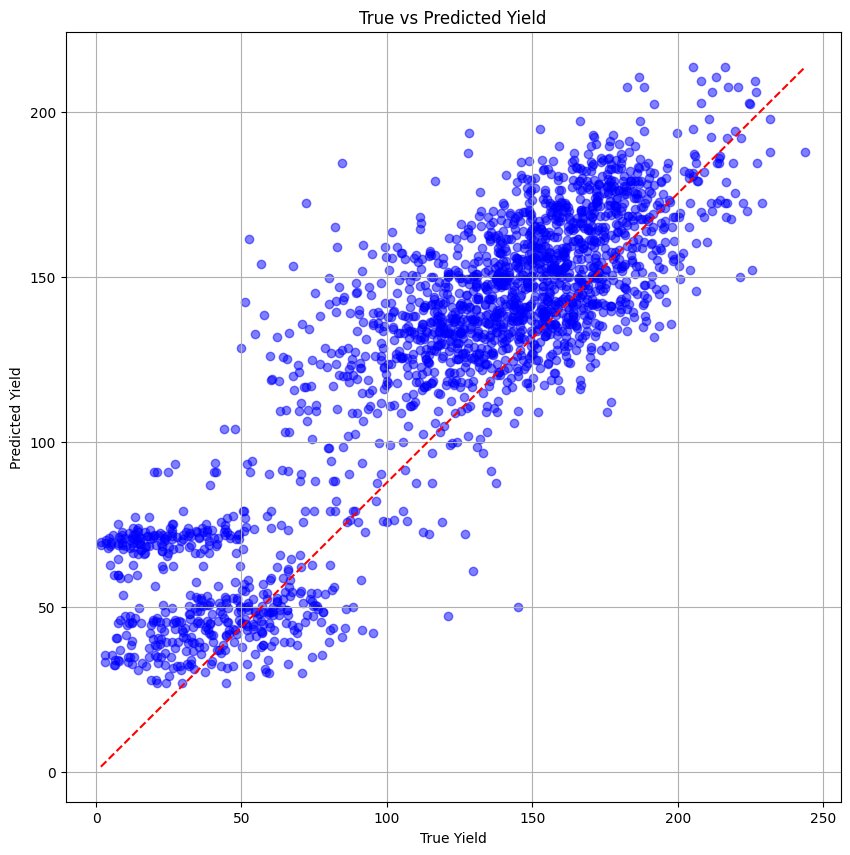

Correlation Coefficient (R^2): 0.7544
Root Mean Square Error (RMSE): 27.0932


In [ ]:
r2, rmse = plot_results(train_data['yieldPerAcre'], train_data['predicted_yield'])

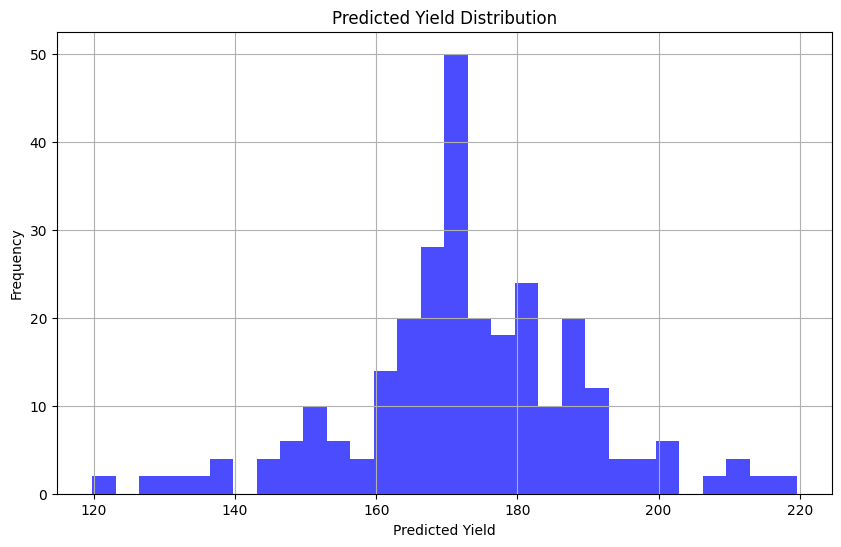

In [ ]:
import matplotlib.pyplot as plt

def plot_predicted_yields(y_pred):
    plt.figure(figsize=(10, 6))
    plt.hist(y_pred, bins=30, color='blue', alpha=0.7)
    plt.title('Predicted Yield Distribution')
    plt.xlabel('Predicted Yield')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

# Plot the predicted yields
plot_predicted_yields(yield_predictions)

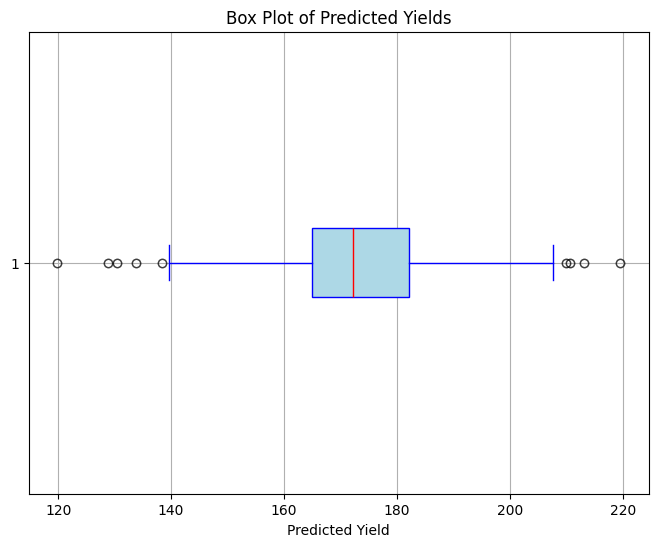

In [ ]:
import matplotlib.pyplot as plt

def plot_boxplot(y_pred):
    plt.figure(figsize=(8, 6))
    plt.boxplot(y_pred, vert=False, patch_artist=True,
                boxprops=dict(facecolor='lightblue', color='blue'),
                medianprops=dict(color='red'),
                whiskerprops=dict(color='blue'),
                capprops=dict(color='blue'),
                flierprops=dict(marker='o', color='red', alpha=0.5))

    plt.title('Box Plot of Predicted Yields')
    plt.xlabel('Predicted Yield')
    plt.grid(True)
    plt.show()

# Plot the box plot of the predicted yields
plot_boxplot(yield_predictions)
